In [76]:
import pickle
import torch
import matplotlib.pyplot as plt
import glob
import random
import pandas as pd
import numpy as np
from adabmDCA.utils import get_device, get_dtype, get_mask_save

import sys
sys.path.append('..')
from selex_dca import *
import selex_dca

## Load saved data

In [61]:
data = []

for filepath in glob.iglob('./saved/*.pkl'):
    if filepath[8:11] == 'Dop':
        with open(filepath, 'rb') as f:
            data.append(pickle.load(f))

print(f"Loaded {len(data)} files.")

data = [data[i] for i in [1,2,0]]

experiment_id_all, round_ids_all, params_all = zip(*data)

Loaded 3 files.


In [58]:
filepath = './saved/wildtypes_sites.pkl'
with open(filepath, 'rb') as f:
    wts = pickle.load(f)

In [3]:
def allequal(x):
    return x.count(x[0]) == len(x)

assert(allequal(round_ids_all))

round_ids = round_ids_all[0]
ts = range(len(round_ids))

## Compare parameters across experiments

In [161]:
params_zerosum_all = [selex_dca.set_zerosum_gauge(get_params_ps(params_all[n])) 
                      for n in range(len(params_all))]

### Couplings

In [163]:
Js = [params_zerosum_all[n]["coupling_matrix"] for n in range(len(params_all))]
Js_flat = [J.reshape(-1) for J in Js]
MJ = torch.stack(Js_flat).numpy()
np.corrcoef(MJ)

array([[1.        , 0.33006176, 0.41791641],
       [0.33006176, 1.        , 0.25813107],
       [0.41791641, 0.25813107, 1.        ]])

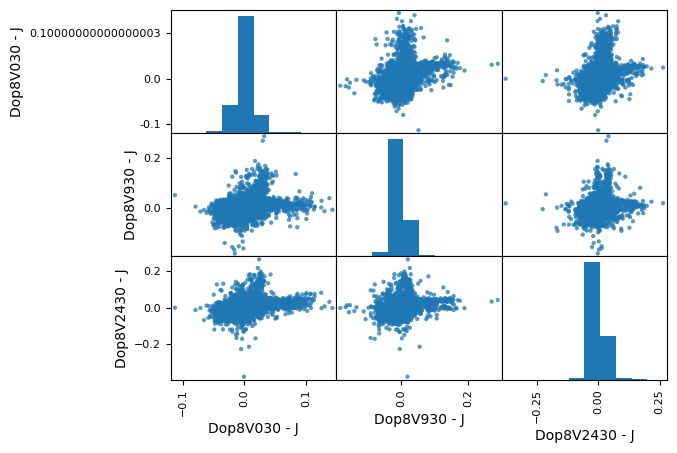

In [164]:
names = [exp + " - J" for exp in experiment_id_all]
df_J = pd.DataFrame(MJ.transpose(), columns=names)
pd.plotting.scatter_matrix(df_J);

In [183]:
def _select(A, idx):
    A2 = A.index_select(0, torch.tensor(idx))
    return A2.index_select(2, torch.tensor(idx))

Indices: range(30, 45)


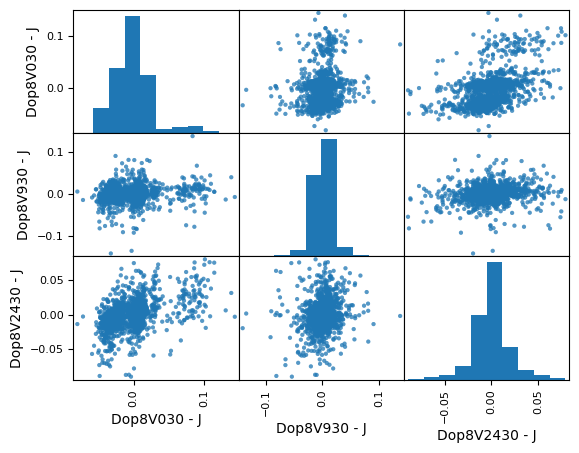

In [200]:
idx_left = range(0, 20)
idx_right = range(30,45)
idx = idx_right
print(f"Indices: {idx}")
Js = [params_zerosum_all[n]["coupling_matrix"] for n in range(len(params_all))]
Js_flat = [_select(J, idx).reshape(-1) for J in Js]
MJ = torch.stack(Js_flat).numpy()
np.corrcoef(MJ)
names = [exp + " - J" for exp in experiment_id_all]
df_J = pd.DataFrame(MJ.transpose(), columns=names)
pd.plotting.scatter_matrix(df_J);

### Biases ps

In [205]:
# hs = [params_all[t]["bias_ps"] for t in ts]
hs = [params_zerosum_all[n]["bias"] for n in range(len(params_all))]
hs_flat = [h.reshape(-1) for h in hs]
Mh = torch.stack(hs_flat).numpy()
np.corrcoef(Mh)

array([[ 1.        , -0.2922729 , -0.45692296],
       [-0.2922729 ,  1.        , -0.21377909],
       [-0.45692296, -0.21377909,  1.        ]])

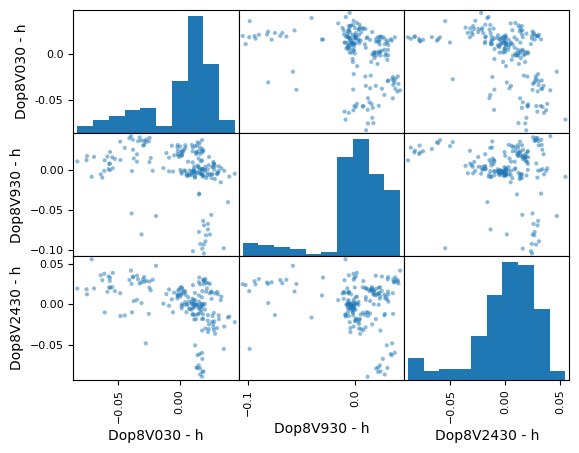

In [206]:
names = [exp + " - h" for exp in experiment_id_all]
df_h = pd.DataFrame(Mh.transpose(), columns=names)
pd.plotting.scatter_matrix(df_h);

Indices: range(0, 45)


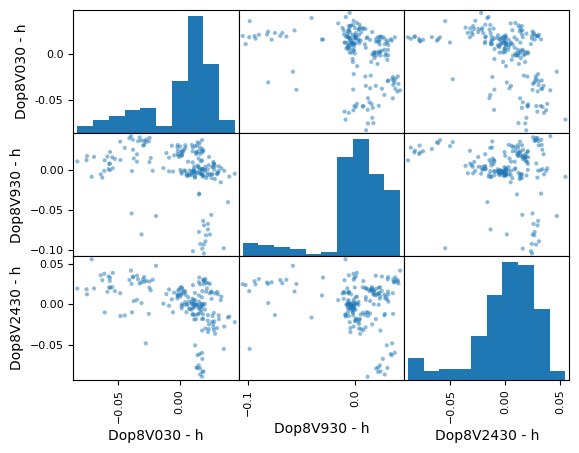

In [209]:
idx_left = range(0, 20)
idx_right = range(30,45)
idx = idx_right
idx = range(45)
print(f"Indices: {idx}")
hs = [params_zerosum_all[n]["bias"] for n in range(len(params_all))]
hs_flat = [h[idx,:].reshape(-1) for h in hs]
Mh = torch.stack(hs_flat).numpy()
np.corrcoef(Mh)
names = [exp + " - h" for exp in experiment_id_all]
df_h = pd.DataFrame(Mh.transpose(), columns=names)
pd.plotting.scatter_matrix(df_h);

### Biases Ns0

In [154]:
ks = [params_all[t]["bias_Ns0"] for t in ts]
ks_flat = [k.reshape(-1) for k in ks]
Mk = torch.stack(ks_flat).numpy()
np.corrcoef(Mk)

array([[ 1.        ,  0.05809224, -0.07358867],
       [ 0.05809224,  1.        , -0.10582138],
       [-0.07358867, -0.10582138,  1.        ]])

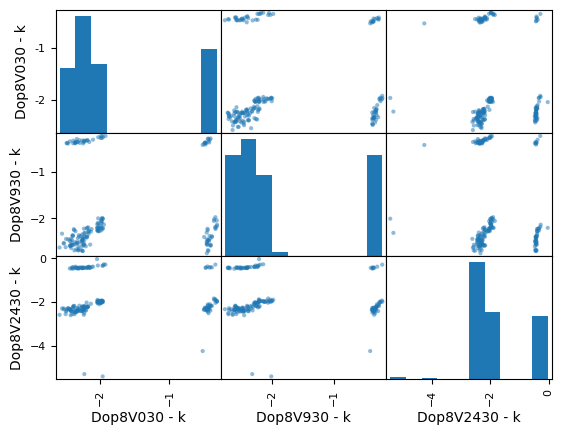

In [155]:
names = [exp + " - k" for exp in experiment_id_all]
df_k = pd.DataFrame(Mk.transpose(), columns=names)
pd.plotting.scatter_matrix(df_k);

<IPython.core.display.Latex object>

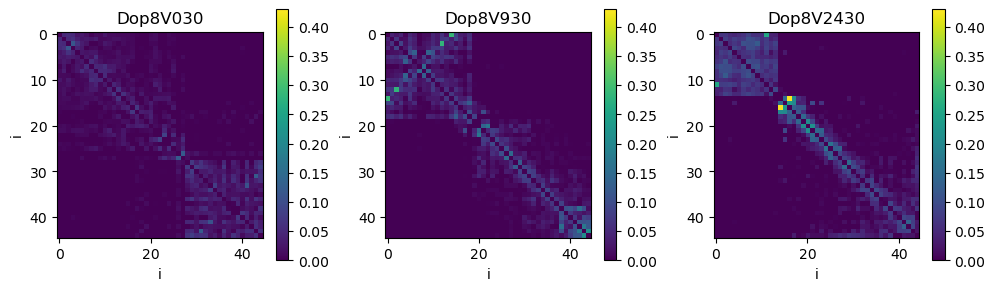

In [139]:
from IPython.display import display, Latex

pl, axes = plt.subplots(1, 3, figsize=(10,3))
for n in range(len(experiment_id_all)):
    ax = axes[n]
    F = selex_dca.get_contact_map(params_zerosum_all[n]["coupling_matrix"])
    im = ax.imshow(F)
    ax.set_xlabel("i"); ax.set_ylabel("i")
    ax.set_title(experiment_id_all[n])
    plt.colorbar(im)
    im.set_clim(0,0.43)
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))
plt.savefig('img/couplings.png')

<IPython.core.display.Latex object>

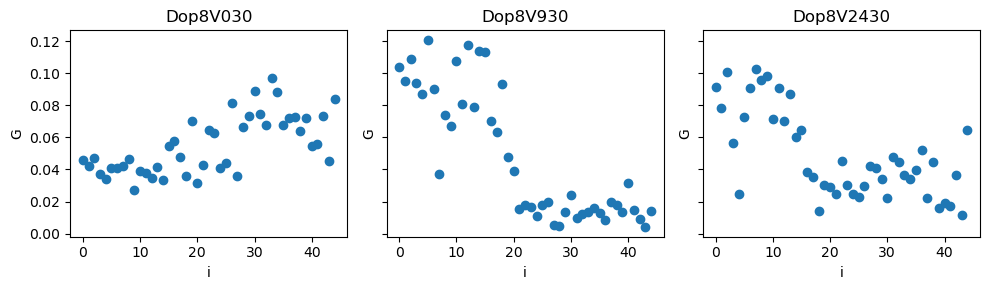

In [147]:
pl, axes = plt.subplots(1, 3, figsize=(10,3), sharey=True)
for n in range(len(experiment_id_all)):
    ax = axes[n]
    h = torch.sqrt(torch.square(params_zerosum_all[n]['bias']).sum(dim=1))
    ax.scatter(range(len(h)), h)
    ax.set_xlabel("i"); ax.set_ylabel("G")
    ax.set_title(experiment_id_all[n])
plt.tight_layout()
display(Latex("$G_{i}=\\sqrt {\\sum_{a}(h_{i}^{a})^2}$"))

## Compare Nst with log-abundances

In [10]:
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


In [11]:
sequences_all = [[sequences_from_file(experiment_id, round_id, device) 
                  for round_id in round_ids] for experiment_id in experiment_id_all];

In [14]:
logNst_all, sequences_unique_all, inverse_indices_all, counts_all = zip(*[compute_logNst(sequences_all[n], params_all[n], round_ids)
                                    for n in range(len(sequences_all))])

In [15]:
logNst_thresh_all = [-100, -100, -100]

In [17]:
X_unique, Y_unique = zip(*[zip(*[vectors_for_scatterplot_single_t_unique(logNst_all[n][t], counts_all[n][t], logNst_thresh_all[n],
                                                  inverse_indices_all[n][t])
                  for t in ts]) for n in range(len(sequences_all))])

# X_nonunique, Y_nonunique = zip(*[zip(*[vectors_for_scatterplot_single_t_nonunique(logNst_all[n][t], counts_all[n][t], logNst_thresh_all[n],
#                                                   inverse_indices_all[n][t])
#                   for t in ts]) for n in range(len(sequences_all))])

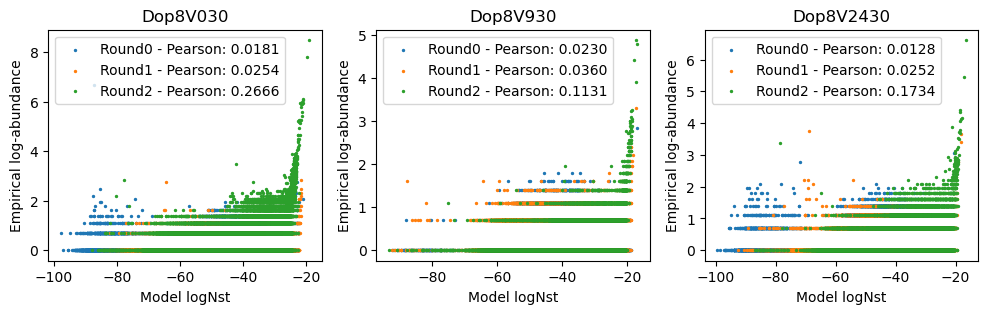

In [21]:
N = 10**5
pl, axes = plt.subplots(1,len(sequences_all), figsize=(4*len(sequences_all),3))

for n in range(len(sequences_all)):
    ax = axes[n]
    for t in ts:
        x = X_unique[n][t]; y = Y_unique[n][t]
        pearson = torch.corrcoef(torch.stack((x, y)))[0,1]
        idx = random.sample(range(len(x)),min(N, len(x)))
        ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson:.{4}f}", s=2)
        ax.set_xlabel("Model logNst")
        ax.set_ylabel("Empirical log-abundance")
        ax.set_title(f"{experiment_id_all[n]}")
    ax.legend()

Compare with chain model:
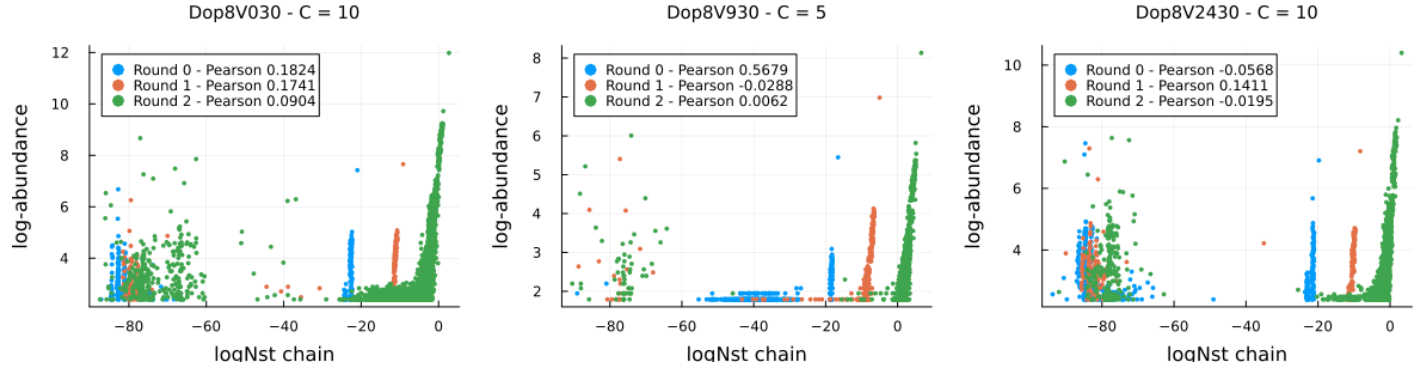

Compare with indep sites:

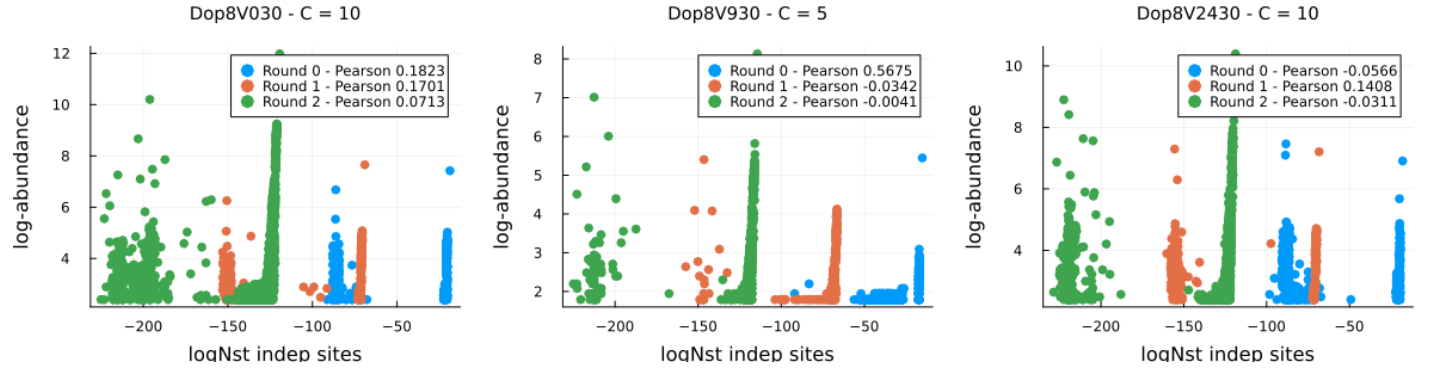

## Compare log-abundances and logps across datasets

In [22]:
n_exp = len(sequences_all)

In [25]:
logps_cross = [[compute_logps(sequences_all[m], get_params_ps(params_all[n]))
    for n in range(n_exp)] for m in range(n_exp)]

In [26]:
def pearson_at_count_thresh(logps_m, logps_n, counts, count_thresh):
    idx_unique_over_thresh = counts >= count_thresh
    x = logps_n[idx_unique_over_thresh]
    y = logps_m[idx_unique_over_thresh]
    return torch.corrcoef(torch.stack((x,y)))[0,1]

/var/folders/4z/by73cp452tnbxp2j1gfzz5n80000gq/T/ipykernel_22907/115026797.py:5: UserWarning: cov(): degrees of freedom is <= 0. Correction should be strictly less than the number of observations. (Triggered internally at /Users/runnerx/miniforge3/conda-bld/libtorch_1764705037409/work/aten/src/ATen/native/Correlation.cpp:116.)
  return torch.corrcoef(torch.stack((x,y)))[0,1]


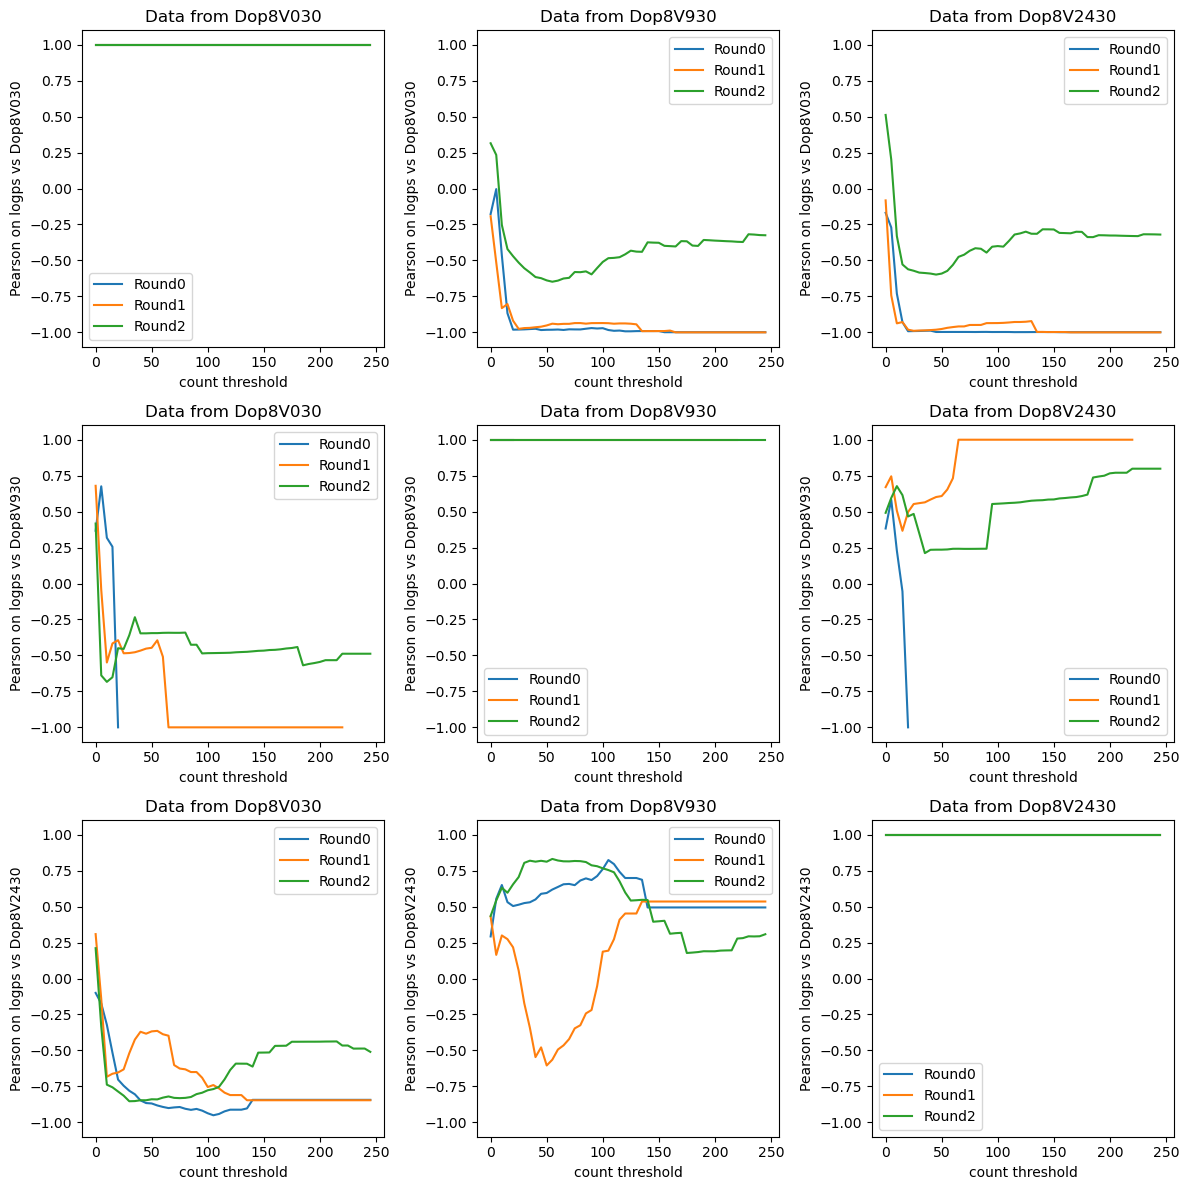

In [27]:
count_thresh_vals = range(0, 250, 5)

pl, axes = plt.subplots(n_exp,n_exp, figsize=(4*n_exp,4*n_exp))

for m in range(n_exp):
    for n in range(n_exp):
        ax = axes[m,n]
        for t in ts:
            pearsons = [
                        pearson_at_count_thresh(logps_cross[m][m][t], logps_cross[m][n][t], counts_all[m][t], count_thresh)
                        for count_thresh in count_thresh_vals
                    ]
            ax.plot(count_thresh_vals, pearsons, label=f"Round{t}")
            ax.set_xlabel("count threshold")
            ax.set_ylabel(f"Pearson on logps vs {experiment_id_all[m]}")
            ax.set_title(f"Data from {experiment_id_all[n]}")
            ax.set_ylim((-1.1,1.1))
        ax.legend()
plt.tight_layout()
plt.savefig('img/logps_cross_pearson.png')

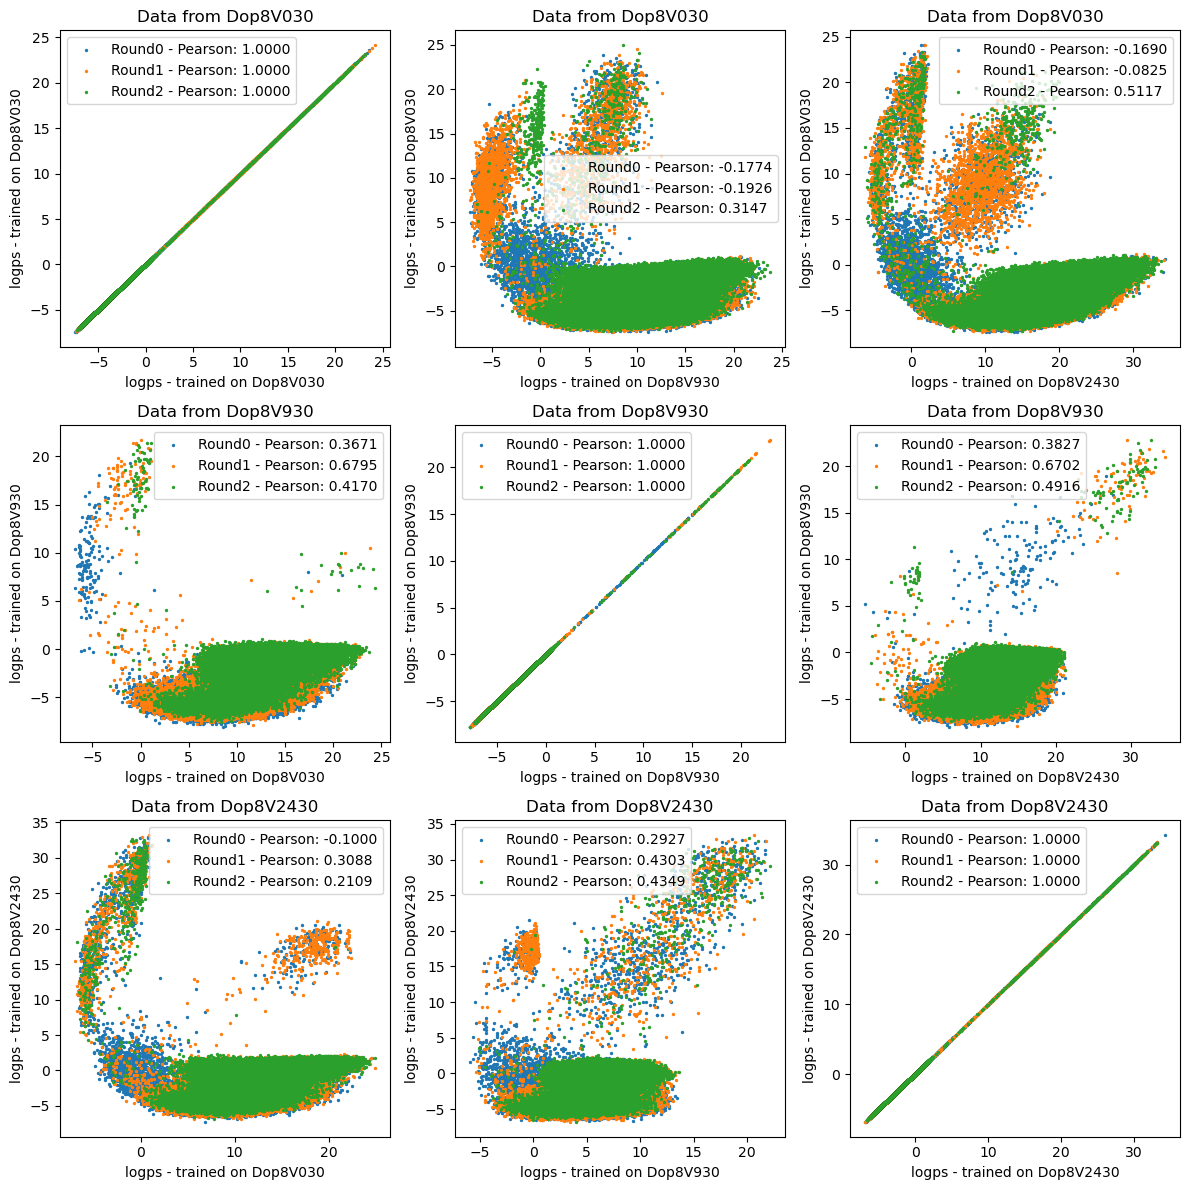

In [28]:
N = 10**5
pl, axes = plt.subplots(n_exp,n_exp, figsize=(4*n_exp,4*n_exp))

for m in range(n_exp):
    for n in range(n_exp):
        ax = axes[m,n]
        for t in ts:
            x = logps_cross[m][n][t]
            y = logps_cross[m][m][t]
            pearson = torch.corrcoef(torch.stack((x,y)))[0,1]            
            idx = random.sample(range(len(x)),min(N, len(x)))
            ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson:.{4}f}", s=2)
            ax.set_xlabel(f"logps - trained on {experiment_id_all[n]}")
            ax.set_ylabel(f"logps - trained on {experiment_id_all[m]}")
            ax.set_title(f"Data from {experiment_id_all[m]}")
        ax.legend()
plt.tight_layout()
plt.savefig('img/logps_cross.png')

In [34]:
logNst_cross, sequences_unique_cross, inverse_indices_cross, counts_cross = zip(*[zip(*[
    selex_dca.compute_logNst(sequences_all[m], params_all[n])
    for n in range(n_exp)]) for m in range(n_exp)])

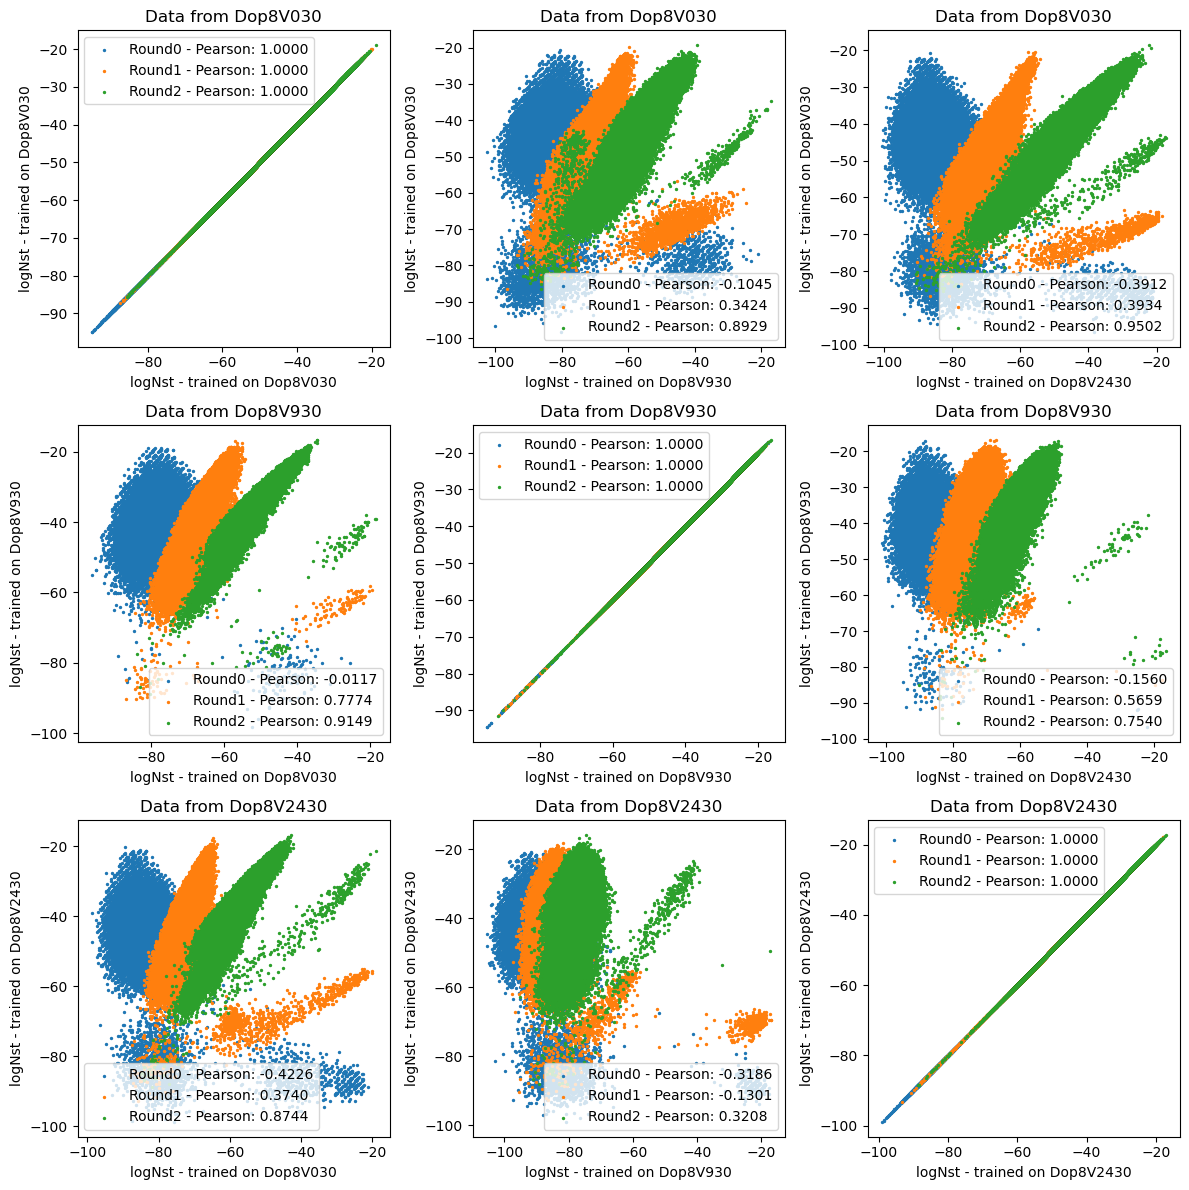

In [36]:
N = 10**5
pl, axes = plt.subplots(n_exp,n_exp, figsize=(4*n_exp,4*n_exp))

for m in range(n_exp):
    for n in range(n_exp):
        ax = axes[m,n]
        for t in ts:
            x = logNst_cross[m][n][t]
            y = logNst_cross[m][m][t]
            pearson = torch.corrcoef(torch.stack((x,y)))[0,1]            
            idx = random.sample(range(len(x)),min(N, len(x)))
            ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson:.{4}f}", s=2)
            ax.set_xlabel(f"logNst - trained on {experiment_id_all[n]}")
            ax.set_ylabel(f"logNst - trained on {experiment_id_all[m]}")
            ax.set_title(f"Data from {experiment_id_all[m]}")
        ax.legend()
plt.tight_layout()
plt.savefig('img/logNst_cross.png')